In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df  = pd.read_csv('storesalesdata.csv')
df.tail()

,Store,Day,Month,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
116227,S0085,27,12,2014,19937.84,5832.48,3257.12,4670.09,5068.66,500.45,1512.22,1776.07,2781.86
116228,S0085,28,12,2014,18328.18,5234.87,3277.48,5531.04,4799.04,150.17,1460.27,1719.40,2113.44
116229,S0085,29,12,2014,18037.09,5197.56,3282.46,5324.82,4704.44,168.80,1311.87,1797.02,2316.13
116230,S0085,30,12,2014,22054.98,6416.92,4127.87,7303.82,6298.13,296.88,1956.34,2136.44,1953.44
116231,S0085,31,12,2014,28148.01,8203.14,4998.97,8781.01,8171.92,626.79,3281.22,3592.13,3123.30


In [3]:
df.drop(['Day','Dry_Grocery','Dairy','Frozen_Food','Meat','Floral','Deli','Bakery','General_Merchandise'],axis=1,inplace=True)

In [4]:
new = df.groupby(['Year','Month'], as_index=False).sum()

In [5]:
new['DATE'] = pd.to_datetime(new[['Year', 'Month']].assign(DAY=1))
new.drop(['Year','Month'],axis=1,inplace=True)

In [6]:
new.DATE = pd.to_datetime(new.DATE)

In [7]:
new = new[['DATE','Produce']]

In [8]:
old = new.iloc[-6:]

In [9]:
new.drop(new.tail(6).index,
        inplace = True)

In [10]:
new.tail()

,DATE,Produce
35,2015-02-01,19772333.34
36,2015-03-01,24608406.71
37,2015-04-01,21559729.45
38,2015-05-01,25792074.59
39,2015-06-01,27212464.15


In [287]:
old.head(10)

,DATE,Produce
40,2015-07-01,26338477.15
41,2015-08-01,23130626.60
42,2015-09-01,20774415.93
43,2015-10-01,20359980.58
44,2015-11-01,21936906.81
45,2015-12-01,20462899.30


In [288]:
# new.to_excel('fuckyou.xlsx')

In [289]:
# new.to_excel('shit.xlsx')

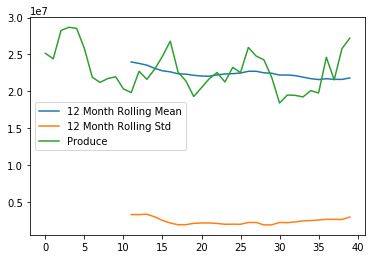

In [290]:
timeseries = new['Produce']
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

<Figure size 432x288 with 0 Axes>

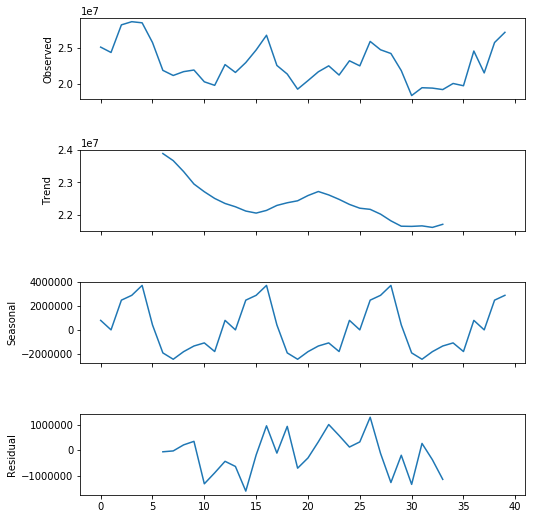

In [291]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(new['Produce'], freq=12)  
figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(8, 8)


In [292]:
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(new['Produce'])
print ('ADF Test:')
labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']

for value,label in zip(test_result,labels):
    print(label+': '+str(value))
if test_result[1] <= 0.05:
    print("Reject null hypothesis and data is stationary")
else:
    print("Fail to reject H0 thereby data is non-stationary ")

ADF Test:
ADF Statistic: -2.7935533984729757
p-value: 0.05920053601744338
No. of Lags Used: 9
Number of Observations Used: 30
Fail to reject H0 thereby data is non-stationary 


In [293]:
def check_adf(time_series):
    test_result = adfuller(timeseries)
    print('ADF Test:')
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']
    for value,label in zip(test_result,labels):
        print (label+': '+str(value))
    if test_result [1] <= 0.05:
        print ("Reject null hypothesis and data is stationary")
    else:
        print ("fail to reject H0 and data is non-stationary ")

In [294]:
new['Produce First Difference'] = new['Produce'] - new['Produce'].shift(1)
check_adf(new['Produce First Difference'].dropna())

ADF Test:
ADF Statistic: -2.7935533984729757
p-value: 0.05920053601744338
No. of Lags Used: 9
Number of Observations Used: 30
fail to reject H0 and data is non-stationary 


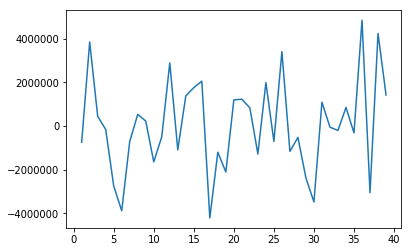

In [295]:
new['Produce First Difference'].plot()

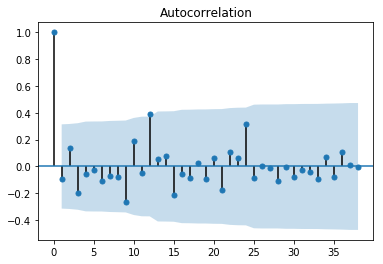

In [296]:
from statsmodels.graphics.tsaplots import plot_acf
fig_first = plot_acf(new["Produce First Difference"].dropna())

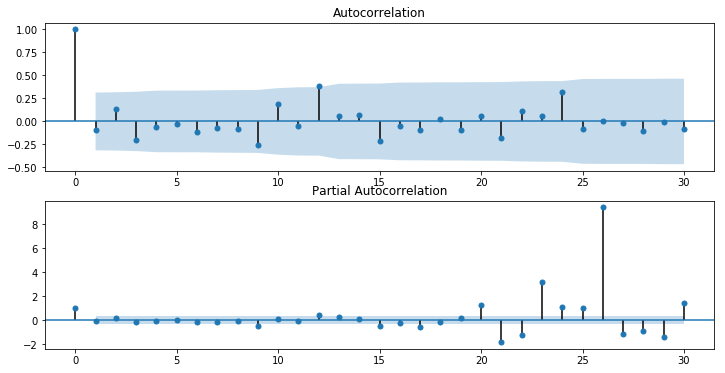

In [329]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(new['Produce First Difference'].dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(new['Produce First Difference'].dropna(), ax=ax[1], lags=30)

In [330]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(new['Produce'],order=(0,1,1), seasonal_order=(1,1,0,12))
ARIMAresult = model.fit()

print(ARIMAresult.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            Produce   No. Observations:                   40
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -428.210
Date:                            Fri, 09 Apr 2021   AIC                            862.421
Time:                                    17:18:39   BIC                            866.308
Sample:                                         0   HQIC                           863.577
                                             - 40                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0331      0.109     -0.304      0.761      -0.247       0.181
ar.S.L12      -0.0632      0.055   

In [331]:
p_ahead = 6
fits = ARIMAresult.forecast(p_ahead)

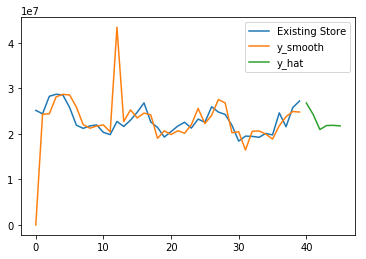

In [369]:
plt.plot(new['Produce'], label='Existing Store')
plt.plot(ARIMAresult.fittedvalues, label='y_smooth')
plt.plot(fits, label='y_hat')
plt.legend()
plt.show()

In [333]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# our guessed parameters
alpha = 0.4
beta = 0.2
gamma = 0.01

# initialise model
ets_model = ExponentialSmoothing(new['Produce'], trend='add', seasonal='add', seasonal_periods=12)
#ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
ets_fit = ets_model.fit(optimized=True)


In [334]:
data = {'trend':'add', 'seasonal': 'add', 'seasonal_periods': '12',}

In [335]:
fuckyoume = HoltWintersResults(ets_fit, params=data)

In [336]:
print(ets_fit.summary())

None


In [337]:
p_ahead = 6
yh = ets_fit.forecast(p_ahead)

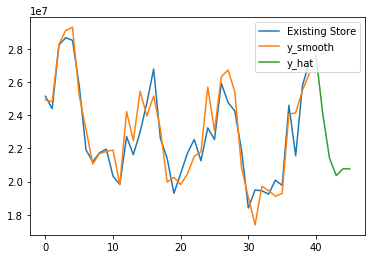

In [338]:
plt.plot(new['Produce'], label='Existing Store')
plt.plot(ets_fit.fittedvalues, label='y_smooth')
plt.plot(yh, label='y_hat')
plt.legend()
plt.show()

In [339]:
ETS_p = pd.DataFrame(yh)

In [340]:
ETS_p.rename(columns={0 : 'ETS Forecast'},inplace=True)

In [341]:
ARIMA_p = pd.DataFrame(fits)

In [342]:
ARIMA_p.rename(columns={0 : 'ARIMA Forecast'}, inplace=True)

In [343]:
old.rename(columns={'Produce': 'Actual'},inplace=True)

In [344]:
f = old.join(ARIMA_p)

In [345]:
f.rename(columns={0:'ARIMA_P'})

,DATE,Actual,ARIMA Forecast
40,2015-07-01,26338477.15,2.677518e+07
41,2015-08-01,23130626.60,2.427706e+07
42,2015-09-01,20774415.93,2.094802e+07
43,2015-10-01,20359980.58,2.183642e+07
44,2015-11-01,21936906.81,2.186235e+07
45,2015-12-01,20462899.30,2.174836e+07


In [346]:
ETS_p

,ETS Forecast
40,2.762835e+07
41,2.411334e+07
42,2.141476e+07
43,2.036366e+07
44,2.077415e+07
45,2.077040e+07


In [347]:
last = f.join(ETS_p)

In [348]:
last.to_excel('last.xlsx')

In [349]:
last.set_index('DATE', inplace=True)


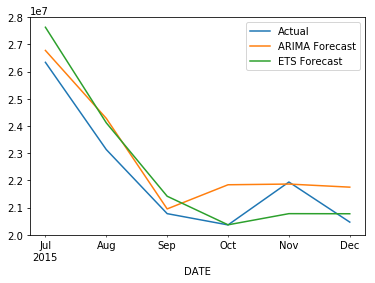

In [350]:
last.plot()

In [377]:
ETS = yh

In [378]:
ARIMA = fits

In [382]:
holdout = old

In [383]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,median_absolute_error,mean_absolute_percentage_error

In [403]:
print("R2 Score of ETS model")
print(r2_score(holdout, ETS))
print("Mean squared error of ETS model")
print(mean_squared_error(holdout, ETS))
print("Mean absolute error of ETS model")
print(mean_absolute_error(holdout,ETS))
print("Median absolute error of ETS model")
print(median_absolute_error(holdout,ETS ))
print("mean absolute oercentage error of ETS model")
print(mean_absolute_percentage_error(holdout,ETS))

R2 Score of ETS model
0.8306566891760001
Mean squared error of ETS model
747687668022.8185
Mean absolute error of ETS model
731146.4472222278
Median absolute error of ETS model
811530.7199465018
mean absolute oercentage error of ETS model
0.03174918015147642


In [404]:
print("R2 Score of ARIMA model")
print(r2_score(holdout, ARIMA))
print("mean squared error of ARIMA model")
print(mean_squared_error(holdout, ARIMA))
print("mean absolute error of ARIMA model")
print(mean_absolute_error(holdout,ARIMA))
print("median absolute error of ARIMA model")
print(median_absolute_error(holdout,ARIMA))
print("mean absolute percentage error of ARIMA model")
print(mean_absolute_percentage_error(holdout,ARIMA))

R2 Score of ARIMA model
0.7971783311582545
mean squared error of ARIMA model
895501923653.7153
mean absolute error of ARIMA model
765534.0516247954
median absolute error of ARIMA model
791567.0489163138
mean absolute percentage error of ARIMA model
0.035539223653687946


In [352]:
from RegscorePy import *

In [405]:
print("AIC Score of ETS model: 176.04")
print("BIC Score of ETS model: 174.12")
print("AIC Score of ARIMA model: 177.04")
print("AIC Score of ARIMA model: 175.87")

AIC Score of ETS model: 176.04
BIC Score of ETS model: 174.12
AIC Score of ARIMA model: 177.04
AIC Score of ARIMA model: 175.87


In [355]:
aic.aic(old['Actual'], fits, p_ahead)

177.12390123947134

In [356]:
bic.bic(old['Actual'], yh, p_ahead)

174.7920638449733

In [357]:
bic.bic(old['Actual'], fits, p_ahead)

175.87445805483966

In [ ]:
new['forecast']=model_fit.predict(start=20,end=38,dynamic=True)
new[['Produce','forecast']].plot(figsize=(12,8))

In [320]:
fuck = pd.read_excel('clustered1.xlsx')
fuck.tail()

,Store,Address,City,State,Zip,Type,Year,Total Sale,Ptc_Dry_Grocery,Ptc_Dairy,Ptc_Frozen_Food,Ptc_Meat,Ptc_Produce,Ptc_Floral,Ptc_Deli,Ptc_Bakery,Ptc_General_Merchandise,cluster
80,S0081,24325 Crenshaw Blvd,Torrance,CA,90503,Existing,2015,14701931.83,0.423280,0.102089,0.086592,0.123493,0.116666,0.008475,0.038956,0.042944,0.057506,2
81,S0082,42170 Big Bear Blvd,Big Bear Lake,CA,92315,Existing,2015,34926733.05,0.460995,0.100760,0.075290,0.113610,0.101490,0.005269,0.048267,0.035212,0.059107,1
82,S0083,130 W Foothill Blvd,Monrovia,CA,91016,Existing,2015,19002814.15,0.447873,0.108865,0.083793,0.109469,0.117443,0.007097,0.031885,0.025206,0.068370,2
83,S0084,5500 Woodruff Ave,Lakewood,CA,90713,Existing,2015,21553681.04,0.460306,0.106343,0.094408,0.105936,0.100824,0.006377,0.040150,0.022119,0.063537,1
84,S0085,561 N Glendale Ave,Glendale,CA,91206,Existing,2015,21552703.64,0.424240,0.112563,0.075257,0.115232,0.125251,0.010635,0.031300,0.036952,0.068570,2


In [321]:
newfuck = fuck[['Store','cluster']]

In [322]:
suck  = pd.read_csv('storesalesdata.csv')
suck.tail()

,Store,Day,Month,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
116227,S0085,27,12,2014,19937.84,5832.48,3257.12,4670.09,5068.66,500.45,1512.22,1776.07,2781.86
116228,S0085,28,12,2014,18328.18,5234.87,3277.48,5531.04,4799.04,150.17,1460.27,1719.40,2113.44
116229,S0085,29,12,2014,18037.09,5197.56,3282.46,5324.82,4704.44,168.80,1311.87,1797.02,2316.13
116230,S0085,30,12,2014,22054.98,6416.92,4127.87,7303.82,6298.13,296.88,1956.34,2136.44,1953.44
116231,S0085,31,12,2014,28148.01,8203.14,4998.97,8781.01,8171.92,626.79,3281.22,3592.13,3123.30


In [323]:
f = suck.merge(newfuck, on='Store')
f.head()

,Store,Day,Month,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise,cluster
0,S0001,1,3,2012,23401.06,5567.90,3930.28,5223.61,4542.28,238.58,2608.78,1651.77,4304.79,1
1,S0001,2,3,2012,32442.93,8009.52,4712.31,6174.72,9503.45,245.29,2692.72,2688.89,4467.51,1
2,S0001,3,3,2012,40433.61,9759.20,5969.03,8010.67,12793.92,282.12,3493.85,2929.85,5721.60,1
3,S0001,4,3,2012,57043.39,13966.26,9008.24,13142.55,16635.77,316.72,5618.55,4270.38,8313.11,1
4,S0001,5,3,2012,32894.86,7870.66,5448.35,5459.29,8358.96,198.00,3339.59,2061.21,5280.16,1


In [324]:
nf = f.groupby(['Store', 'cluster','Year','Month'], as_index=False).sum()
nf.head()

,Store,cluster,Year,Month,Day,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
0,S0001,1,2012,3,496,1067703.95,233985.14,155166.80,225170.47,225673.98,21675.30,101809.42,77006.78,156945.15
1,S0001,1,2012,4,465,943879.65,200299.99,155998.34,216787.83,209257.48,9969.36,90967.51,69797.70,146573.55
2,S0001,1,2012,5,496,986573.32,203033.25,159929.02,226422.54,239711.93,18662.12,94298.67,75046.83,159597.43
3,S0001,1,2012,6,465,955377.11,190142.23,174658.83,204284.23,249080.61,7745.86,96336.42,70991.65,144022.40
4,S0001,1,2012,7,496,945024.03,198793.34,165896.02,213794.29,241885.27,7634.52,103923.93,71490.19,149828.89


In [325]:
nf.shape

(3830, 14)

In [326]:
shit = nf.groupby(['cluster', 'Year','Month'], as_index=False).mean()
shit.head()

,cluster,Year,Month,Day,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
0,1,2012,3,496.0,1.308566e+06,280385.796970,199380.829091,294132.433030,283025.337273,26020.112424,106147.173333,70475.252727,187502.207879
1,1,2012,4,465.0,1.196507e+06,251680.707273,201142.933333,289174.340909,272278.448788,14231.863636,108120.522424,64556.850303,174267.860606
2,1,2012,5,496.0,1.263487e+06,252858.924848,208467.640606,303986.673636,316019.881818,28143.973030,112785.324848,70970.443030,193009.190606
3,1,2012,6,465.0,1.201523e+06,237693.775152,215340.721212,284843.447576,317595.568788,13141.320303,115577.376970,69030.511818,182571.317576
4,1,2012,7,496.0,1.207263e+06,245938.582727,206929.798485,300781.169091,312175.940606,10364.383333,124259.696970,72361.548485,186801.723636


In [327]:
shit.shape

(138, 13)

In [328]:
shit['DATE'] = pd.to_datetime(shit[['Year', 'Month']].assign(DAY=1))
shit.drop(['Year','Month'],axis=1,inplace=True)

In [329]:
shit.DATE = pd.to_datetime(shit.DATE)

In [330]:
new = shit[['DATE','Produce','cluster']]

In [78]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# our guessed parameters
alpha = 0.4
beta = 0.2
gamma = 0.01

# initialise model
ets_model1 = ExponentialSmoothing(new['Produce'], trend='add', seasonal='add', seasonal_periods=12)
#ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
ets_fit1 = ets_model1.fit(optimized=True)


In [79]:
ahead = 6
yhh = ets_fit1.forecast(ahead)

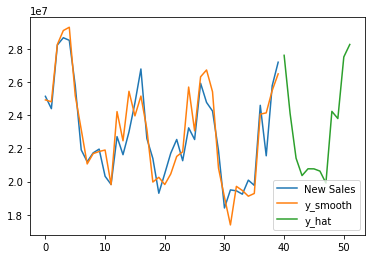

In [80]:
plt.plot(new['Produce'], label='New Sales')
plt.plot(ets_fit1.fittedvalues, label='y_smooth')
plt.plot(yhh, label='y_hat')
plt.legend()
plt.show()

In [81]:
yhh

40    2.762835e+07
41    2.411334e+07
42    2.141476e+07
43    2.036366e+07
44    2.077415e+07
45    2.077040e+07
46    2.063475e+07
47    1.991113e+07
48    2.424331e+07
49    2.380952e+07
50    2.753090e+07
51    2.828441e+07
dtype: float64

In [338]:
new.tail()

,DATE,Produce,cluster
133,2015-08-01,313711.103125,3
134,2015-09-01,282532.060625,3
135,2015-10-01,269372.215000,3
136,2015-11-01,295499.451875,3
137,2015-12-01,278337.060000,3


In [341]:
new.set_index('DATE',inplace=True)
new.head()

,Produce,cluster
DATE,,
2012-03-01,283025.337273,1
2012-04-01,272278.448788,1
2012-05-01,316019.881818,1
2012-06-01,317595.568788,1
2012-07-01,312175.940606,1


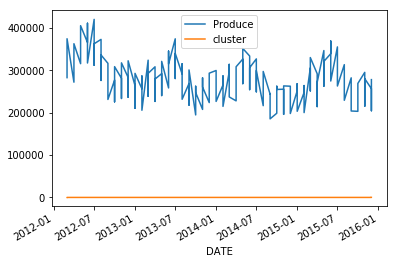

In [343]:
new.plot()